# Making animations with Matplotlib

In this notebook, we will learn how to create animated figures using Matplotlib. The whole process is a little tricky and potentially unintuitive but animations can provide us with insight into the data.

Most of this tutorial is adapted from: http://tiao.io/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import xarray as xr

## Create some data - The Lorenz 63 model

Let's get some data to plot. For fun, we will use the famous Lorenz model from 1963. Here are the equations:

$\frac{dx}{dt} = \sigma (y-x)$

$\frac{dy}{dt} = x (\rho - z) -y$

$\frac{dz}{dt} = xy - \beta z$

In [2]:
# Define the default parameters values
sigma = 10
rho = 28
beta = 8/3

We will create a Python class for the model.

In [3]:
class L63():
    def __init__(self, sigma, rho, beta, init, dt):
        self.sigma, self.rho, self.beta = sigma, rho, beta 
        self.x, self.y, self.z = init
        self.dt = dt
        self.hist = [init]
    
    def step(self):
        self.x += (self.sigma * (self.y - self.x)) * self.dt
        self.y += (self.x * (self.rho - self.z)) * self.dt
        self.z += (self.x * self.y - self.beta * self.z) * self.dt
        self.hist.append([self.x, self.y, self.z])
    
    def integrate(self, n_steps):
        for n in range(n_steps): self.step()

Now we will integrate two models with slightly different initial conditions.

In [4]:
l1 = L63(sigma, rho, beta, init=[1, 10, 20], dt=1e-2)
l1.integrate(3000)

In [5]:
l2 = L63(sigma, rho, beta, init=[1.1, 10, 20], dt=1e-2)
l2.integrate(3000)

In [6]:
# The hist attribute contains the history for the three variables x, y, and z
np.array(l1.hist).shape

(3001, 3)

In [7]:
# Grab every tenth time step to speed up plotting
y1 = np.array(l1.hist)[::10, 0]
y2 = np.array(l2.hist)[::10, 0]

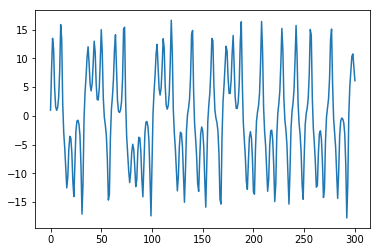

In [8]:
# We want to animate something like this
plt.plot(y1);

## Line plot animation

To create an animation we first need to create a figure and an axis object.

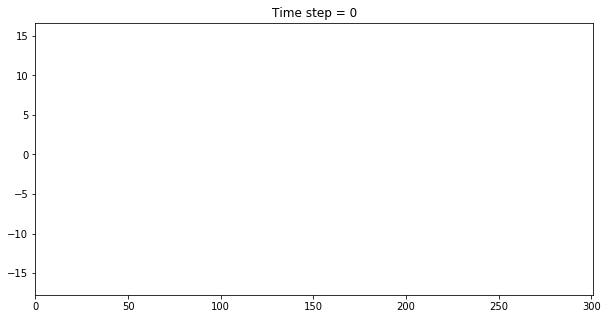

In [9]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.set_ylim(np.min(y1), np.max(y1))
ax.set_xlim(0, len(y1))
ax.set_title('Time step = 0');

This is our empty plot now.

Next up we need to create some line plot objects. In our case, we want to have two, one for each simulation.

In [10]:
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)

Now we define a animate function, which takes an integer - the time step - as an input, updates the line plot data and returns the line plot objects.

In [11]:
def animate(i):
    line1.set_data(range(i), y1[:i])
    line2.set_data(range(i), y2[:i])
    ax.set_title(f'Time step = {i}')
    return (line1, line2,)   # Note that the comma is important!

The last step is to pass the figure object and the animation function the the matplotlib.animation.FuncAnimation class along with the number of frames, i.e. time steps and the interval between frames in milliseconds. 

In [12]:
anim = animation.FuncAnimation(fig, animate, frames=300, interval=100, blit=True)

For viewing the animation inside the notebook we can create an HTML animation...

In [13]:
HTML(anim.to_html5_video())

... or save the animation as an mp4 file...

In [14]:
anim.save('tmp.mp4')

## 3D plots

Let's briefly explore how we can create 3D plots.

In [15]:
def plot_attractor(hists):
    if np.array(hists).ndim == 2: hists = [hists]
    hists = [np.array(h) for h in hists]
    fig = plt.figure(figsize=(10, 10)); ax = fig.gca(projection='3d')
    [ax.plot(h[:,0], h[:,1], h[:,2]) for h in hists]

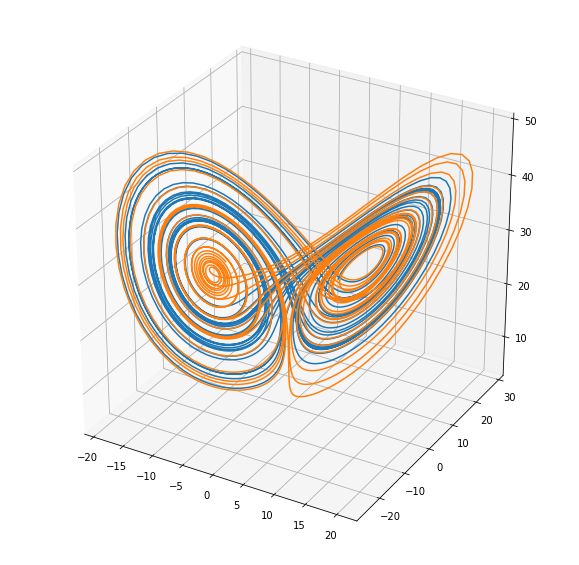

In [16]:
plot_attractor([l1.hist, l2.hist])

## 2D animations

We can do the same thing with 2D plots and we can even use the xarray API.

In [17]:
ds = xr.open_dataset('../week4/CAM02.nc', decode_times=False)

In [18]:
ds

<xarray.Dataset>
Dimensions:  (lat: 64, lev: 30, lon: 128, time: 24)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...
  * lon      (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * lev      (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 87.82 ...
  * time     (time) float64 1.0 1.042 1.083 1.125 1.167 1.208 1.25 1.292 ...
Data variables:
    TAP      (time, lev, lat, lon) float32 ...
    SOLIN    (time, lat, lon) float32 ...

In [19]:
ds.time.size

24

This time let's be good Python users and wrap everything up inside a function.

In [20]:
def animate_2D():
    fig, ax = plt.subplots(figsize=(10, 7))
    I = ds['SOLIN'].isel(time=0).plot(ax=ax)
    def animate(i):
        I = ds['SOLIN'].isel(time=i).plot(ax=ax, add_colorbar=False)
        return (I,)
    plt.close()   # Not necessary but will avoid a stray figure popping up
    return animation.FuncAnimation(fig, animate, frames=ds.time.size, interval=150, blit=True)

In [21]:
anim = animate_2D()

In [22]:
HTML(anim.to_html5_video())

We can also create a JavaScript widget for more interactivity.

In [23]:
HTML(anim.to_jshtml())